In [2]:
# Step 1: Load the necessary libraries
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import mixed_precision

In [3]:
# Step 2: Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
# Enable mixed precision training (if supported by your GPU)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Step 3
# Use lines=True because the JSON file is likely line-delimited
df = pd.read_json(r"C:\Users\71591\Desktop\dataset\News_Category_Dataset_v3.json", lines=True)

# Step 4: Keep both 'headline' and 'short_description' columns along with 'category'
df = df[['headline', 'short_description', 'category']]

# Step 5: Find the top 10 most frequent categories
top_categories = df['category'].value_counts().head(10).index

# Filter the dataset to include only the top 10 categories
df = df[df['category'].isin(top_categories)]

In [9]:
# Step 6: Filter the dataset to include only the top 10 frequent categories
df_filtered = df[df['category'].isin(top_categories)]

# Step 7: Combine 'headline' and 'short_description' into one text column
df_filtered['text'] = df_filtered['headline'] + " " + df_filtered['short_description']

# Step 8: Initialize the Sentence-Transformer model for sentence embeddings (use CPU)
from sentence_transformers import SentenceTransformer

# Use 'cpu' instead of 'cuda' for SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Step 9: Generate sentence embeddings for each row in the 'text' column
X = model.encode(df_filtered['text'].tolist(), convert_to_tensor=False)  # List of sentence embeddings


C:\Users\71591\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Step 10: Encode the target labels ('category') using LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df_filtered['category'])
y = to_categorical(y)  # Convert labels to one-hot encoded format

# Step 11: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 12: Build the Keras neural network model
model_nn = Sequential()

# Add input layer (Dense layer with 512 units)
model_nn.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))

# Add dropout layer for regularization
model_nn.add(Dropout(0.5))

# Add hidden layer
model_nn.add(Dense(256, activation='relu'))

# Add dropout layer for regularization
model_nn.add(Dropout(0.5))

# Add output layer with softmax activation (for multi-class classification)
model_nn.add(Dense(y_train.shape[1], activation='softmax'))

# Step 13: Compile the model
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


C:\Users\71591\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Step 14: Train the model
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.7029 - loss: 0.9151 - val_accuracy: 0.8011 - val_loss: 0.5858
Epoch 2/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8009 - loss: 0.6132 - val_accuracy: 0.8087 - val_loss: 0.5614
Epoch 3/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.8102 - loss: 0.5789 - val_accuracy: 0.8141 - val_loss: 0.5492
Epoch 4/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.8203 - loss: 0.5401 - val_accuracy: 0.8177 - val_loss: 0.5359
Epoch 5/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8283 - loss: 0.5166 - val_accuracy: 0.8208 - val_loss: 0.5297
Epoch 6/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.8358 - loss: 0.4936 - val_accuracy: 0.8202 - val_loss: 0.5335
Epoch 7/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.8381 - loss: 0.4786 - val_accuracy: 0.8234 - val_loss: 0.5290
Epoch 8/10
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8435 -

In [12]:
# Step 15: Evaluate the model
loss, accuracy = model_nn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8197 - loss: 0.5450
Test Loss: 0.5307764410972595
Test Accuracy: 0.8253065347671509


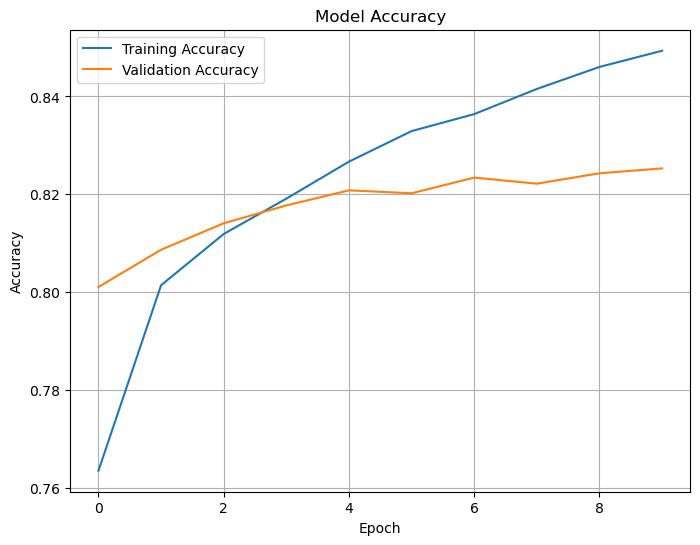

In [13]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


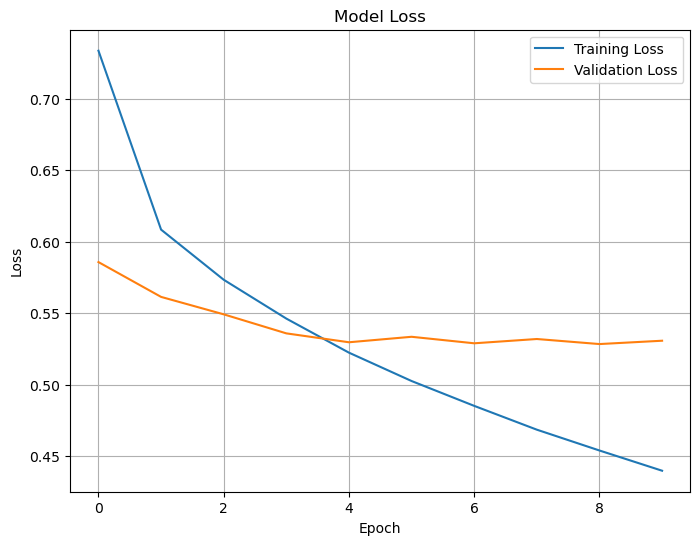

In [14]:
# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


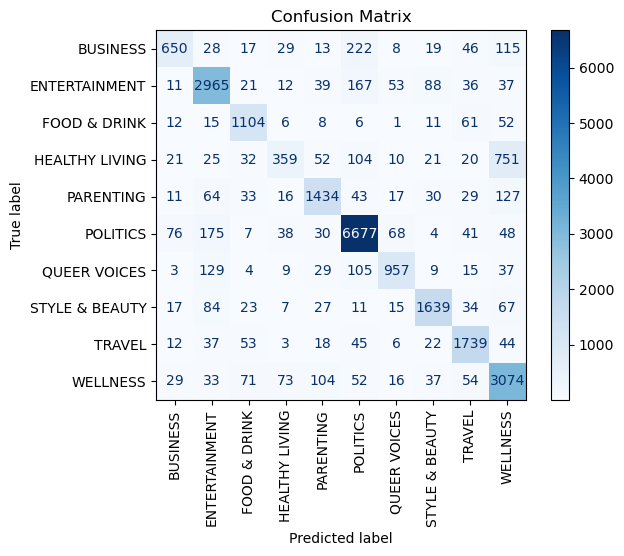

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes for test data
y_pred = model_nn.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))


                precision    recall  f1-score   support

      BUSINESS       0.77      0.57      0.65      1147
 ENTERTAINMENT       0.83      0.86      0.85      3429
  FOOD & DRINK       0.81      0.87      0.84      1276
HEALTHY LIVING       0.65      0.26      0.37      1395
     PARENTING       0.82      0.79      0.81      1804
      POLITICS       0.90      0.93      0.91      7164
  QUEER VOICES       0.83      0.74      0.78      1297
STYLE & BEAUTY       0.87      0.85      0.86      1924
        TRAVEL       0.84      0.88      0.86      1979
      WELLNESS       0.71      0.87      0.78      3543

      accuracy                           0.83     24958
     macro avg       0.80      0.76      0.77     24958
  weighted avg       0.82      0.83      0.82     24958



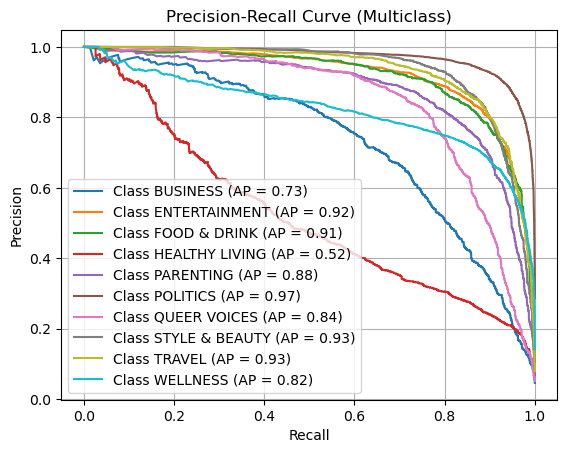

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass
y_test_binarized = label_binarize(y_true, classes=range(y_train.shape[1]))

# Compute precision-recall curve for each class
for i in range(y_train.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_test_binarized[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f"Class {encoder.classes_[i]} (AP = {average_precision:.2f})")

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Multiclass)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


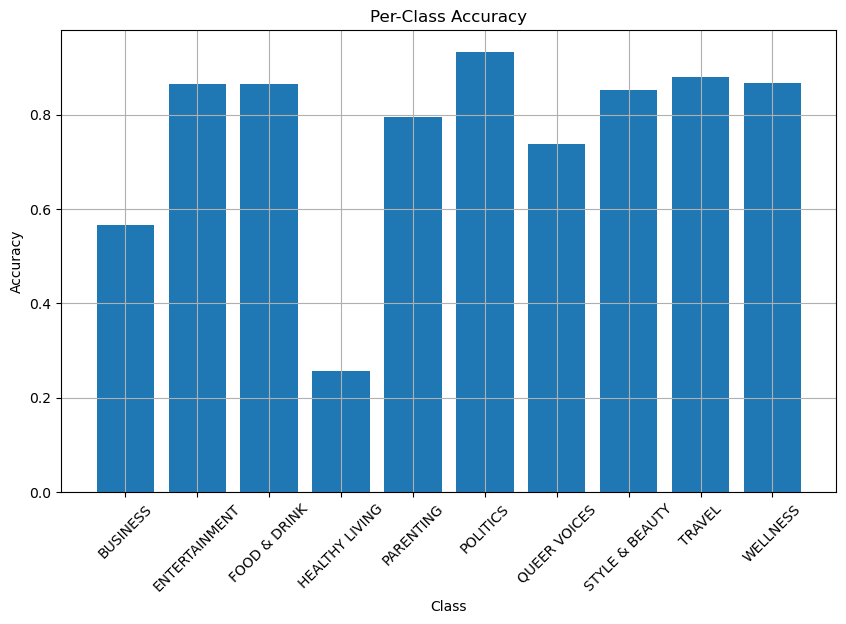

In [19]:
from sklearn.metrics import accuracy_score

# Calculate per-class accuracy
class_accuracies = {}
for i, class_label in enumerate(encoder.classes_):
    class_indices = [idx for idx in range(len(y_true)) if y_true[idx] == i]
    class_accuracies[class_label] = accuracy_score(
        [y_true[idx] for idx in class_indices],
        [y_pred_classes[idx] for idx in class_indices]
    )

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


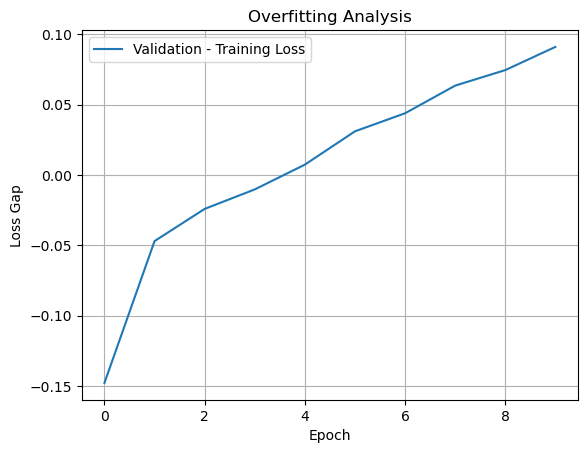

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

overfit_gap = [val - train for train, val in zip(train_loss, val_loss)]

plt.plot(overfit_gap, label="Validation - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Gap")
plt.title("Overfitting Analysis")
plt.legend()
plt.grid(True)
plt.show()
